In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy as scp

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets

import time

import pickle as pkl
import os
import shutil


### 
import sys 
sys.path.append("..")
from utils import get_data
from random_search import *

# 
from model_ln import LinearNonlinear
from training_lnl import train, correlation, normalize, get_sample
### 


In [2]:
"""
returns: (X_local, X_global, chirp, types, sampling_frequency, exp_time,
            local_m, local_sd, global_m, global_sd)
"""
X_local, X_global, chirp, types, sampling_frequency, *_  = get_data(normalize=True, data_dir='../data')

In [3]:
# global local at the same time
celltypes = np.ones(28)
celltypes[0:5]=-1
celltypes[14:19] = -1
model = LinearNonlinear(celltypes,
                       noise_init_scale=0.01)
stimulus = torch.tensor(chirp,  dtype=torch.float32)

In [4]:
out = model.forward(stimulus).T

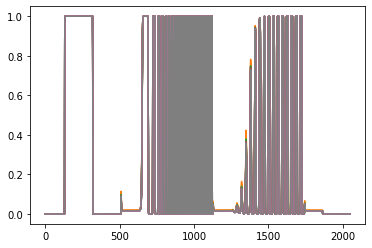

0 14
1 15
2 16
3 17
4 18


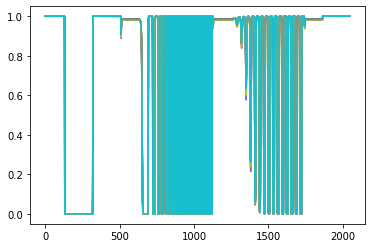

In [5]:
for i in range(5,14):
    plt.plot(out.detach()[i])
    plt.plot(out.detach()[i+14])

plt.show()

for i in range(5):
    plt.plot(out.detach()[i])
    plt.plot(out.detach()[i+14])
    print(i, i+14)



In [7]:
"""
training 
simple training
"""

log_dir = ''
log_file=None 

#delete and create log_dir if not existing
if os.path.isdir(log_dir):
    shutil.rmtree(log_dir)
os.mkdir(log_dir)

config = {'hash':None,
          'lr':1e-1,
          'max_steps': 5000,
          'time_reg_weight':0,
          'decrease_lr_after': 100,
          'stop_after': 10
                 }
########################################################################################
# define cell types
# global local at the same time
celltypes = np.ones(28)
celltypes[0:5]=-1
celltypes[14:19] = -1

model = LinearNonlinear(celltypes,
                        noise_init_scale=0.01,
                        seed = 0)

# load data
(X_local, X_global, chirp, types, sampling_frequency, exp_time,
 local_m, local_sd, global_m, global_sd) = get_data(normalize=True, data_dir='../data')

# set stim and response
stimulus = chirp.astype(np.float32)
response = np.vstack([X_global,X_local])
response = response.astype(np.float32)

train(
    model,
    stimulus,
    response,
    log_dir=log_dir,
    log_interval=100,
    time_reg_weight=config['time_reg_weight'],
    lr=config['lr'],
    max_steps=config['max_steps'],
    decrease_lr_after=config['decrease_lr_after'],
    stop_after=config['stop_after'],
    verbose=True
)

Step 100 (0.54s), Loss: Total=-0.7380677461624146, Trace=-0.7380677461624146, Speed_reg=0.00e+00, 
Step 200 (0.36s), Loss: Total=-0.7419517916440964, Trace=-0.7419517916440964, Speed_reg=0.00e+00, 
lowering learning rate to  0.05
Step 300 (0.31s), Loss: Total=-0.727639964222908, Trace=-0.727639964222908, Speed_reg=0.00e+00, 
lowering learning rate to  0.025
Step 400 (0.33s), Loss: Total=-0.7191968137025833, Trace=-0.7191968137025833, Speed_reg=0.00e+00, 
lowering learning rate to  0.0125
Step 500 (0.35s), Loss: Total=-0.7225980681180953, Trace=-0.7225980681180953, Speed_reg=0.00e+00, 
lowering learning rate to  0.00625
Step 600 (0.38s), Loss: Total=-0.7228348541259766, Trace=-0.7228348541259766, Speed_reg=0.00e+00, 
lowering learning rate to  0.003125
Step 700 (0.32s), Loss: Total=-0.7227499413490296, Trace=-0.7227499413490296, Speed_reg=0.00e+00, 
lowering learning rate to  0.0015625
Step 800 (0.37s), Loss: Total=-0.7226928865909577, Trace=-0.7226928865909577, Speed_reg=0.00e+00, 
low

In [8]:

with open(log_dir+'/loss_tracking.pkl', "rb") as f:
    loss_dict = pkl.load(f)
    
best_loss = loss_dict['best_loss']
track_loss = loss_dict['track_loss']
#track_lr_change = loss_dict[ 'track_lr_change']
#track_lr = loss_dict[  'track_lr']
#track_best_indeces = loss_dict[ 'track_best_indeces']
#traces = loss_dict['traces']
runtime = loss_dict['runtime']

print('runtime', runtime)

runtime 4.158573865890503


best corr: -0.747123658657074


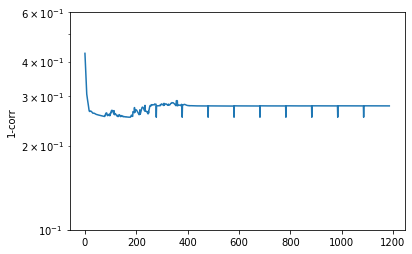

In [9]:
plt.semilogy(1+np.array(track_loss))
plt.ylabel('1-corr')
plt.ylim(0.1,0.6)
print('best corr:', best_loss)

In [10]:
# load best model
model.load_state_dict(
                    torch.load(os.path.join(log_dir, 'model.pth')))

<All keys matched successfully>

In [11]:
stimulus = torch.tensor(chirp,  dtype=torch.float32).to('cuda')
out = model.forward(stimulus).detach().cpu().T

In [12]:
out.shape


torch.Size([28, 2048])

In [13]:
response_unnorm = torch.tensor(np.vstack([X_global, X_local]), dtype=torch.float32)
response = normalize(response_unnorm.T).T

# get correlation for each trace
y_pred_unnorm = np.array(out.detach())
y_pred_np = np.array(normalize(out.detach().T)).T
corr_pred = np.zeros(28)
for i in range(28):
    corr_pred[i] = np.corrcoef(y_pred_unnorm[i],response_unnorm[i])[0,1]

print(corr_pred)
print(np.mean(corr_pred))

print('check with correlation:', correlation(response.T, normalize(out.detach().T)))

[0.49730706 0.70952972 0.69322617 0.4452715  0.57829062 0.3908602
 0.78057278 0.76035239 0.77815773 0.90054103 0.89437691 0.87840112
 0.89791589 0.53980198 0.6738892  0.6711016  0.69739926 0.66813206
 0.68955772 0.86241862 0.83254879 0.83584263 0.85285684 0.87401181
 0.88690583 0.86630988 0.88491011 0.87897302]
0.7471236594852215
check with correlation: tensor(0.7471)


In [14]:
print(model.log_kernel_speed[:14])
print(model.log_kernel_speed[14:])

tensor([0.1065, 0.9556, 0.7562, 0.1842, 0.1886, 0.2384, 0.5657, 0.6532, 0.0809,
        0.9950, 0.2638, 0.7234, 0.5051, 0.3004], device='cuda:0',
       grad_fn=<SliceBackward>)
tensor([0.6262, 0.8799, 0.7666, 0.5267, 0.6914, 0.4386, 0.5908, 0.5431, 0.2505,
        0.9195, 0.2337, 0.6236, 0.5865, 0.5336], device='cuda:0',
       grad_fn=<SliceBackward>)


In [15]:
np.corrcoef(model.log_kernel_speed[:14].cpu().detach(),model.log_kernel_speed[14:].cpu().detach())

array([[1.        , 0.73302075],
       [0.73302075, 1.        ]])

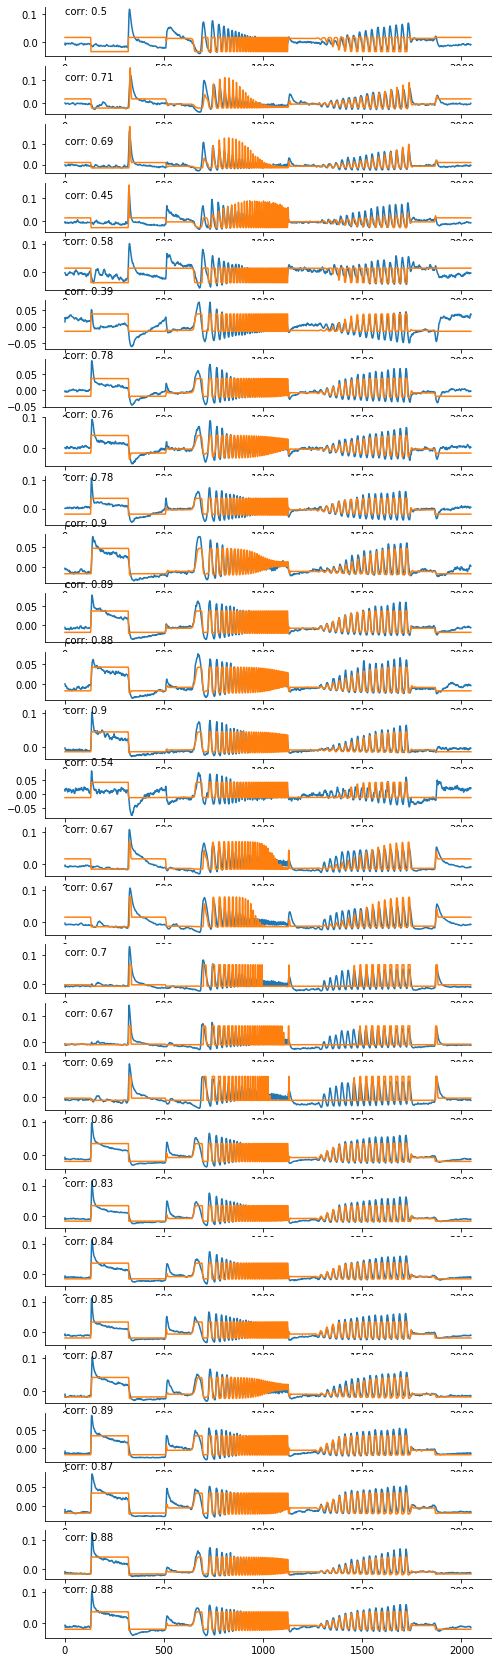

In [16]:
plt.figure(1, figsize = (8,30))
for cellindex in range(28):
    plt.subplot(28, 1, cellindex+1)
    plt.text(0,0.1,'corr: '+str(corr_pred[cellindex].round(2)))
    plt.plot(response[cellindex], label='data')
    plt.plot(y_pred_np[cellindex], label='model')    
sns.despine()
#plt.legend()

### random search

In [ ]:
"""
training
random search
"""
data_mode = 'glocal_zchirp_v2' # in ['local', 'global', 'glocal_std']

random_search=True
n_runs = 100

log_file=None 

args = {'log_dir': '',
       'log_interval':100}

args['log_dir'] = args['log_dir']+ data_mode+'/'



# define cell types
# global local at the same time
celltypes = np.ones(28)
celltypes[0:5]=-1
celltypes[14:19] = -1

# load data
(y_local, y_global, chirp, types, sampling_frequency, exp_time,
 local_m, local_sd, global_m, global_sd) = get_data(normalize=True, data_dir='../data')

# set stim and response
stimulus = chirp.astype(np.float32)

response = np.vstack([y_global,y_local])

# random search
if random_search:
    # ToDO: add seed 
    #while True:
    for i in range(n_runs):
        config = get_sample()
        model = LinearNonlinear(celltypes,
                    noise_init_scale=config['noise_init_scale'],
                    seed = config['seed'])
        
        if config['hash'] in os.listdir(args['log_dir']):
            while True:
                config['hash'] += 1
                if config['hash'] not in os.listdir(args['log_dir']):
                    break
        log_dir = os.path.join(args['log_dir'], str(config['hash']))
        os.mkdir(log_dir)
        train(
            model,
            stimulus,
            response,
            log_dir=log_dir,
            log_interval=args['log_interval'],
            #time_reg_weight=config['time_reg_weight'],
            lr=config['lr'],
            max_steps=config['max_steps'],
            decrease_lr_after=config['decrease_lr_after'],
            stop_after=config['stop_after'],
            verbose=False
        )
        # and save configs:
        with open(log_dir+'/config.pkl', "wb") as f:
            pkl.dump(config,f)


else:
    config = get_sample()
    model = LinearNonlinear(celltypes,
                                noise_init_scale=config['noise_init_scale'],
                                seed=config['seed'])
    if config['hash'] in os.listdir(args['log_dir']):
        while True:
            config['hash'] += 1
            if config['hash'] not in os.listdir(args['log_dir']):
                break
    log_dir = os.path.join(args['log_dir'], str(config['hash']))
    os.mkdir(log_dir)

    train(
            model,
            stimulus,
            response,
            log_dir=log_dir,
            log_interval=args['log_interval'],
            #time_reg_weight=config['time_reg_weight'],
            lr=config['lr'],
            max_steps=config['max_steps'],
            decrease_lr_after=config['decrease_lr_after'],
            stop_after=config['stop_after'],
            verbose=False
        )
    with open(log_dir+'/config.pkl', "wb") as f:
        pkl.dump(config,f)